In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skimage

# Import Data
and visualize a few examples

In [2]:
!curl -o keren.tar.gz https://storage.googleapis.com/bebi205-spring2023/keren.tar.gz
!tar -xzvf keren.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3238M  100 3238M    0     0  76.7M      0  0:00:42  0:00:42 --:--:-- 98.7M
keren/
keren/Point01.npz
keren/Point02.npz
keren/Point04.npz
keren/Point05.npz
keren/Point06.npz
keren/Point07.npz
keren/Point08.npz
keren/Point09.npz
keren/Point10.npz
keren/Point11.npz
keren/Point12.npz
keren/Point13.npz
keren/Point14.npz
keren/Point15.npz
keren/Point16.npz
keren/Point17.npz
keren/Point18.npz
keren/Point19.npz
keren/Point20.npz
keren/Point21.npz
keren/Point22.npz
keren/Point23.npz
keren/Point24.npz
keren/Point25.npz
keren/Point26.npz
keren/Point27.npz
keren/Point28.npz
keren/Point29.npz
keren/Point30.npz
keren/Point31.npz
keren/Point32.npz
keren/Point33.npz
keren/Point34.npz
keren/Point35.npz
keren/Point36.npz
keren/Point37.npz
keren/Point38.npz
keren/Point39.npz
keren/Point40.npz
keren/Point41.npz
keren/meta.yaml


In [3]:
p1 = np.load('keren/Point39.npz', allow_pickle=True)
X1 = p1['X']
Y1 = p1['y']
C1 = p1['cell_types']
C1 = C1.item()

In [4]:
import matplotlib.pyplot as plt

In [5]:
y0 = Y1[0,:,:,0]
y1 = Y1[0,:,:,1]

Checking out the y mask

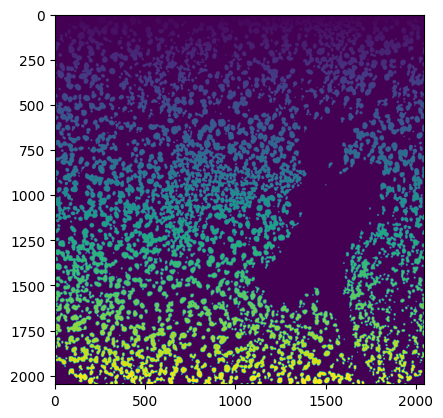

In [6]:
plt.imshow(Y1[0][:,:,1])

Mapping the instance segmentation to semantic segmentation via cell types

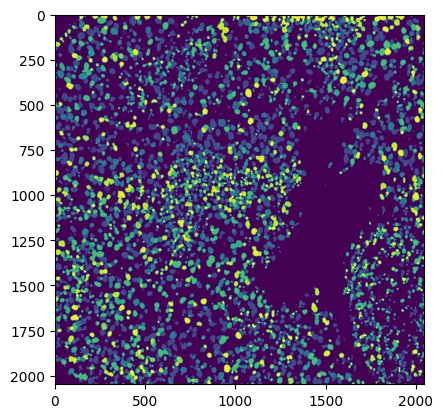

In [7]:
f = lambda x: C1.get(x)
f_vec = np.vectorize(f)
y_ = f_vec(y1)
plt.imshow(y_)

In [8]:
X_n = skimage.exposure.equalize_hist(X1[0])


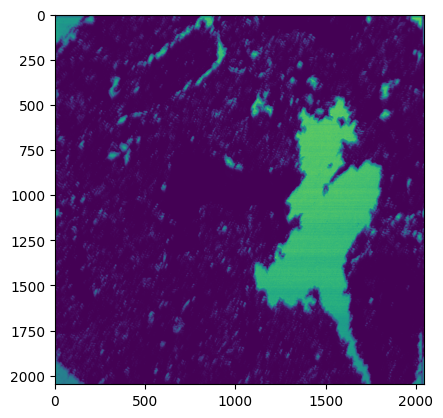

In [9]:
plt.imshow(X1[0,:,:,43])

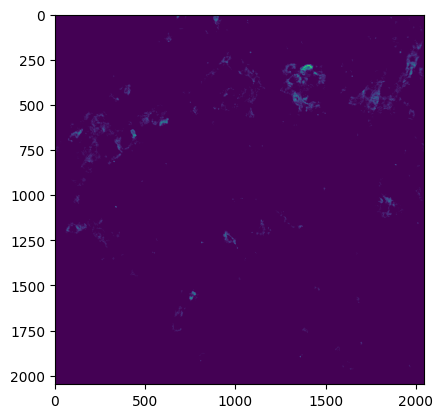

In [10]:
plt.imshow(X_n[:,:,30])

# Making training data




In [11]:
def normalize(X):
  X_n = []
  for c in range(51):
    X_n.append(skimage.exposure.equalize_hist(X[:,:,c]))
  return np.array(X_n)
  
def load_img(num):
  id = str(num)
  if num < 10:
    id = '0' + str(num)
  p = np.load('keren/Point'+id+'.npz', allow_pickle=True)
  if(len(p['X'])) > 1:
    print('multiple images in file:',id)
  X = p['X'][0]
  Y = p['y'][0]
  C = p['cell_types']
  C = C.item()

  X_n = normalize(X)
  
  return X,Y,C

def get_cell_box(cell_coord):
  y = cell_coord.transpose()[0]
  x = cell_coord.transpose()[1]

  y_min = np.min(y)
  y_max = np.max(y)

  x_min = np.min(x)
  x_max = np.max(x)

  return y_min,y_max,x_min,x_max

def avg_whole_cell_size(Y_cyto):
  """ chooses 100 random whole cell segmentations, 
      prints std deviation and returns avg dimension"""
  sample = np.random.choice(np.unique(Y_cyto),size = 100)
  x_len = []
  y_len = []
  n = 0
  for cell in sample:
    if cell == 0:
      continue
    cell_coord = np.argwhere(Y_cyto == cell)
    y_min,y_max,x_min,x_max = get_cell_box(cell_coord)
    x_len.append( x_max-x_min)
    y_len.append( y_max-y_min)
    n+=1
  print('. x avg:',np.mean(x_len),'x std:',np.std(x_len))
  print('. y avg:',np.mean(y_len),'y std:',np.std(y_len))
  avg_size = int((np.mean(x_len)+np.mean(y_len))/2)
  print('. size =',avg_size)
  return avg_size

def get_coord(Y):
  """ input: Y
      returns: bounding boxes for nuclei as well as average bounding box size
      for whole cells"""
  Y_nuc = Y[:,:,0]
  Y_cyto = Y[:,:,1]

  size = avg_whole_cell_size(Y_cyto)
  
  values = np.unique(Y_nuc)
  coords = {}
  for cell in values:
    if cell == 0:
      continue
    cell_coord = np.argwhere(Y_nuc == cell)
    y_min,y_max,x_min,x_max = get_cell_box(cell_coord)
    coords[cell] = [y_min,y_max,x_min,x_max]

  return coords,size

def crop_cell(X,cell,coords,size = 0):
  """crops cell via bounding box generated by nucleus centroid and size. 
    size argument currently is the average whole cell size"""

  coords_ = coords.copy()
  if size != 0:
    center_y =(coords_[0]+coords_[1])/2
    center_x = (coords_[2]+coords_[3])/2
    
    coords_[0] = max([0,int(center_y-size/2)])
    coords_[1] = min(2048,int(center_y+size/2))
    coords_[2] = max([0,int(center_x-size/2)])
    coords_[3] = min(2048,int(center_x+size/2))

  X_cell = X[coords_[0]:coords_[1],coords_[2]:coords_[3],:]
  return X_cell

def preprocess(X,Y,C,size = 21):
  """ input: full sized image (pre-normalized) 
      output: list of [cropped image of cell,cell type]"""
  coords,size = get_coord(Y)
  
  cell_images = []
  for cell, box in coords.items():
    cell_images.append([crop_cell(X,cell,box,size = size),C.get(cell)])
  return cell_images

In [12]:
header = [
 'file',
 'cell_type',
 'Au',
 'B7H3',
 'Beta-catenin',
 'C',
 'CD11b',
 'CD11c',
 'CD138',
 'CD16',
 'CD163',
 'CD20',
 'CD209',
 'CD3',
 'CD31',
 'CD4',
 'CD45',
 'CD45RO',
 'CD56',
 'CD63',
 'CD68',
 'CD8',
 'CSF-1R',
 'Ca',
 'EGFR',
 'Fe',
 'FoxP3',
 'H3K27me3',
 'H3K9ac',
 'HLA-DR',
 'HLA-Class-1',
 'IDO',
 'Keratin17',
 'Keratin6',
 'Ki67',
 'Lag3',
 'MPO',
 'Na',
 'OX40',
 'P',
 'PDL1',
 'PD1',
 'PanCK',
 'SMA',
 'Si',
 'Ta',
 'Vimentin',
 'dsDNA',
 'p53',
 'pS6',
 'background',
 'sum of H3K27me3, H3K9ac, and dsDNA',
 'sum_PanCK_CD45',]

In [14]:
cell_dict = {  0: 'Background',
  1: 'Unidentified',
  2: 'Endothelial',
  3: 'Mesenchyme',
  4: 'Tumor',
  5: 'Tregs',
  6: 'CD4T',
  7: 'CD8T',
  8: 'CD3T',
  9: 'Nk',
  10: 'Bcell',
  11: 'Neutrophil',
  12: 'Macrophage',
  13: 'DC',
  14: 'DC_Mono',
  15: 'Mono_Neu',
  16: 'Immune_other',
  17: 'FAILED_HARMONIZATION',}

In [15]:
df = []
cell_images = None
for img_num in range(1,6):#42)
  if img_num == 3:
    continue
  print("img:",img_num)
  X,Y,C = load_img(img_num)
  cell_images = preprocess(X,Y,C)
  i = 0
  for cell in cell_images:
    
    row = [img_num,cell_dict.get(cell[1])]
    for c in range(51):
      c_mean = np.mean(cell[0][:,:,c])
      row.append(c_mean)
    df.append(row)


img: 1
. x avg: 18.81 x std: 6.178503054947856
. y avg: 19.41 y std: 6.477800552656742
. size = 19
img: 2
. x avg: 23.33 x std: 10.71359416815851
. y avg: 24.54 y std: 11.140394966068303
. size = 23
img: 4
. x avg: 21.38 x std: 7.58522247531343
. y avg: 22.02 y std: 8.206070923407864
. size = 21
img: 5
. x avg: 19.94 x std: 8.803203962194674
. y avg: 21.21 y std: 9.357665307115873
. size = 20


In [45]:
df = pd.DataFrame(df,columns = header)
df.to_csv('data.csv')
df

,file,cell_type,Au,B7H3,Beta-catenin,C,CD11b,CD11c,CD138,CD16,...,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,background,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
0,1,FAILED_HARMONIZATION,0.614035,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.377193,0.052632,0.000000,1.600877,0.0,0.197368,0.083333,3.304135,0.223684
1,1,FAILED_HARMONIZATION,3.635965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.394737,2.618421,0.000000,0.464912,0.0,0.052632,0.061404,1.003383,0.596491
2,1,FAILED_HARMONIZATION,0.866667,0.0,0.000000,0.0,0.0,0.0,0.017544,0.000000,...,0.000000,0.389474,0.063158,0.080702,5.670175,0.0,0.273684,0.094737,15.537744,0.203509
3,1,FAILED_HARMONIZATION,0.894737,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.385965,0.049123,0.000000,13.000000,0.0,0.866667,0.147368,39.654737,0.347368
4,1,FAILED_HARMONIZATION,4.814035,0.0,0.000000,0.0,0.0,0.0,0.084211,0.000000,...,0.000000,0.543860,1.842105,0.000000,7.877193,0.0,0.287719,0.084211,17.511278,0.498246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20902,5,FAILED_HARMONIZATION,0.939286,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,1.828571,0.464286,0.182143,3.407143,6.267857,0.0,0.657143,0.089286,14.811414,0.371429
20903,5,FAILED_HARMONIZATION,0.807692,0.0,0.146154,0.0,0.0,0.0,0.000000,0.000000,...,3.488462,0.288462,0.084615,4.484615,2.773077,0.0,0.150000,0.084615,6.878638,0.950000
20904,5,FAILED_HARMONIZATION,0.609375,0.0,0.000000,0.0,0.0,0.0,0.000000,0.009375,...,0.000000,0.406250,0.059375,3.381250,3.350000,0.0,0.131250,0.071875,7.904139,0.481250
20905,5,FAILED_HARMONIZATION,0.730000,0.0,0.626667,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.506667,0.043333,0.000000,0.336667,0.0,1.083333,0.063333,2.136486,0.306667


# Make Correlation Heatmap

In [46]:
df = pd.read_csv('data.csv')

,Unnamed: 0,file,cell_type,Au,B7H3,Beta-catenin,C,CD11b,CD11c,CD138,...,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,background,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
0,0,1,FAILED_HARMONIZATION,0.614035,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.377193,0.052632,0.000000,1.600877,0.0,0.197368,0.083333,3.304135,0.223684
1,1,1,FAILED_HARMONIZATION,3.635965,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.394737,2.618421,0.000000,0.464912,0.0,0.052632,0.061404,1.003383,0.596491
2,2,1,FAILED_HARMONIZATION,0.866667,0.0,0.000000,0.0,0.0,0.0,0.017544,...,0.000000,0.389474,0.063158,0.080702,5.670175,0.0,0.273684,0.094737,15.537744,0.203509
3,3,1,FAILED_HARMONIZATION,0.894737,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.385965,0.049123,0.000000,13.000000,0.0,0.866667,0.147368,39.654737,0.347368
4,4,1,FAILED_HARMONIZATION,4.814035,0.0,0.000000,0.0,0.0,0.0,0.084211,...,0.000000,0.543860,1.842105,0.000000,7.877193,0.0,0.287719,0.084211,17.511278,0.498246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20902,20902,5,FAILED_HARMONIZATION,0.939286,0.0,0.000000,0.0,0.0,0.0,0.000000,...,1.828571,0.464286,0.182143,3.407143,6.267857,0.0,0.657143,0.089286,14.811414,0.371429
20903,20903,5,FAILED_HARMONIZATION,0.807692,0.0,0.146154,0.0,0.0,0.0,0.000000,...,3.488462,0.288462,0.084615,4.484615,2.773077,0.0,0.150000,0.084615,6.878638,0.950000
20904,20904,5,FAILED_HARMONIZATION,0.609375,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.406250,0.059375,3.381250,3.350000,0.0,0.131250,0.071875,7.904139,0.481250
20905,20905,5,FAILED_HARMONIZATION,0.730000,0.0,0.626667,0.0,0.0,0.0,0.000000,...,0.000000,0.506667,0.043333,0.000000,0.336667,0.0,1.083333,0.063333,2.136486,0.306667


In [17]:
means = df.groupby(['cell_type']).mean()
columns_to_drop = ['file','Au','C','P','Fe','Ca','background']
means = means.drop(labels = columns_to_drop,axis=1)
means

,B7H3,Beta-catenin,CD11b,CD11c,CD138,CD16,CD163,CD20,CD209,CD3,...,PanCK,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
cell_type,,,,,,,,,,,,,,,,,,,,,
Bcell,0.000000,0.006150,0.000843,0.019793,0.015504,0.003900,0.000000,1.557456,0.000084,0.032708,...,0.033084,0.028991,0.430081,0.682389,0.548423,7.683383,0.000006,0.743668,29.571497,1.121012
CD3T,0.000000,0.031148,0.002114,0.015320,0.033795,0.012935,0.000000,0.095869,0.000396,0.222291,...,0.038234,0.123863,0.539812,0.940570,1.960451,8.390598,0.000000,0.665672,33.958175,1.115665
CD4T,0.000000,0.026665,0.007214,0.143883,0.023641,0.078548,0.000000,0.297228,0.003020,0.334922,...,0.013131,0.087596,0.490366,1.097378,2.777622,6.815708,0.000039,0.648064,30.600350,1.919391
CD8T,0.000000,0.065218,0.004723,0.076975,0.021890,0.130307,0.000000,0.082602,0.008416,0.215819,...,0.027940,0.151230,0.666777,2.318625,2.509576,7.517390,0.000000,0.542254,27.177515,1.447126
DC,0.000000,0.012649,0.000000,0.000851,0.008938,0.491187,0.006569,0.039820,0.391411,0.031472,...,0.013117,0.032938,0.933652,6.171559,4.567503,6.484201,0.000416,0.227382,18.036936,0.775267
DC_Mono,0.000000,0.055050,0.021279,0.308350,0.019731,0.063289,0.000252,0.071458,0.001216,0.070804,...,0.009601,0.126416,0.541528,1.184341,3.330462,6.805406,0.000179,0.680906,27.095266,0.981445
Endothelial,0.000000,0.253128,0.001836,0.007781,0.033507,0.017216,0.000000,0.013372,0.001083,0.009958,...,0.000148,0.468330,0.775224,2.976918,5.001824,6.871690,0.000000,0.555367,25.769112,0.149645
FAILED_HARMONIZATION,0.000000,0.123045,0.006213,0.056629,0.025361,0.126764,0.000000,0.090172,0.010555,0.042266,...,0.122486,0.064539,1.802043,6.139560,1.644496,4.815682,0.001112,0.291830,15.201321,0.596742
Immune_other,0.000000,0.016036,0.000625,0.012200,0.078145,0.013287,0.000000,0.032965,0.000155,0.022090,...,0.007952,0.112751,0.515159,0.863083,1.530532,7.741538,0.000000,0.967901,32.766021,0.509355


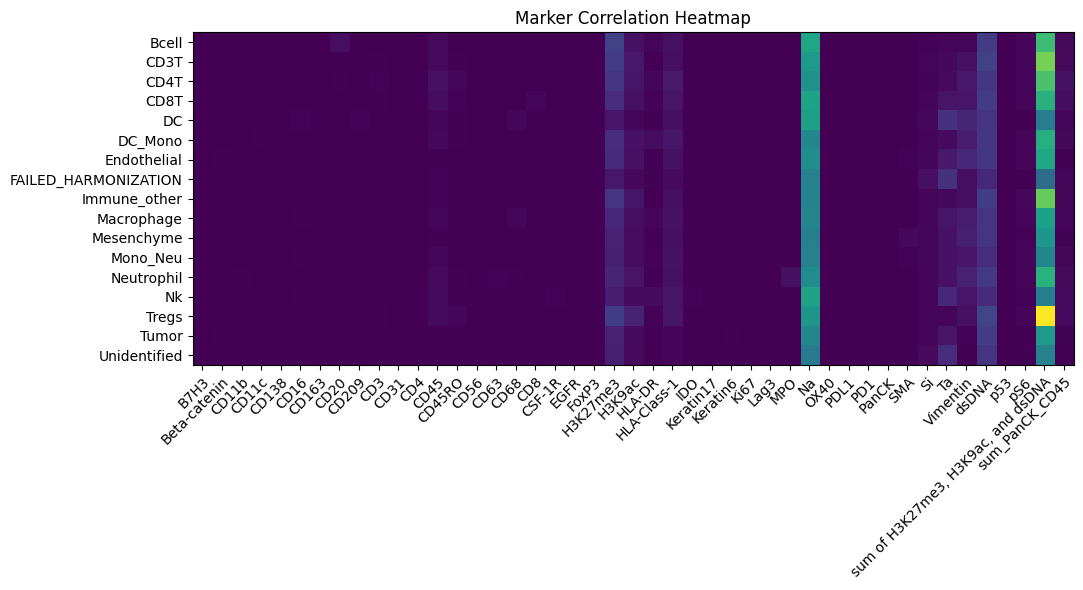

In [44]:
cell_types = means.index.values
markers = means.columns.values



fig, ax = plt.subplots(figsize = (20,6))
im = ax.imshow(means.values)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(markers)), labels=markers, fontsize = 10)
ax.set_yticks(np.arange(len(cell_types)), labels=cell_types, fontsize = 10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

ax.set_title("Marker Correlation Heatmap")
fig.tight_layout()
plt.savefig('marker_heatmap.png')
plt.show()

# Logistic Regression Classifier

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [20]:
training_data = df.copy()
columns_to_drop = ['file','Au','C','P','Fe','Ca','background']
rows_to_drop = ['FAILED_HARMONIZATION','Unidentified']
training_data = training_data.drop(labels = columns_to_drop,axis=1)
training_data = training_data[training_data.cell_type.apply(lambda x: x not in rows_to_drop)]
training_data

,cell_type,B7H3,Beta-catenin,CD11b,CD11c,CD138,CD16,CD163,CD20,CD209,...,PanCK,SMA,Si,Ta,Vimentin,dsDNA,p53,pS6,"sum of H3K27me3, H3K9ac, and dsDNA",sum_PanCK_CD45
71,Bcell,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,1.714681,0.0,...,0.000000,0.0000,0.382271,0.213296,0.0000,14.789474,0.0,1.252078,51.504551,0.939058
72,Macrophage,0.0,0.00,0.138504,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0000,43.213296,81.207756,0.0000,5.000000,0.0,0.969529,13.461417,0.166205
73,Tumor,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.288089,0.0000,0.277008,0.698061,0.0000,1.803324,0.0,0.060942,4.593431,0.288089
75,Tumor,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.487535,0.0000,7.556787,10.285319,0.0000,9.598338,0.0,0.401662,21.663395,0.490305
76,CD8T,0.0,0.00,0.000000,0.0,0.083102,0.0,0.0,0.155125,0.0,...,0.041551,0.0000,0.498615,3.626039,0.0000,9.171745,0.0,0.337950,22.490859,0.911357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20824,CD8T,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0000,0.450000,0.990000,4.7150,17.625000,0.0,0.792500,55.458193,0.580000
20825,Tumor,0.0,0.06,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.090000,0.0000,0.602500,0.187500,0.2875,11.940000,0.0,0.697500,42.432517,0.117500
20826,Immune_other,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0000,0.440000,0.092500,0.0000,12.160000,0.0,0.000000,25.870439,0.380000
20828,Tumor,0.0,0.27,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.005000,0.0000,0.882500,0.355000,0.0000,8.515000,0.0,0.917500,39.413007,0.005000


In [21]:
reverse_map = { 'Background': 0,
  'Unidentified':1,
  'Endothelial':2,
  'Mesenchyme':3,
   'Tumor':4,
   'Tregs':5,
   'CD4T':6,
   'CD8T':7,
   'CD3T':8,
   'Nk':9,
   'Bcell':10,
   'Neutrophil':11,
   'Macrophage':12,
   'DC':13,
   'DC_Mono':14,
   'Mono_Neu':15,
   'Immune_other':16,
   'FAILED_HARMONIZATION':17,}

In [22]:
y = training_data.cell_type.map(reverse_map).values
y.shape

(18588,)

In [23]:
np.unique(y,return_counts= True)

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 425,  542, 7789,  237, 1169, 1183,  769,   20, 1432,  211, 2515,
          40,  923,  257, 1076]))

Interestingly, there is a class imbalance with many Tregs (4) but few DC_mono (40) or Nk (20) cells. However, the confusion matrix shows very poor accuracy on Tregs.

In [24]:
X = (training_data.drop(labels = ['cell_type'],axis = 1)).values
X.shape

(18588, 45)

In [56]:
log = LogisticRegression(C=1,max_iter = 10000,class_weight = 'balanced')
length = len(y)
test_index = int(0.8*length)
log.fit(X[0:test_index], y[0:test_index])   # Fit the ridge regression model to the data

print(log.score(X[test_index:], y[test_index:] ))

y_pred = log.predict(X[test_index:])
cm = confusion_matrix(y[test_index:], y_pred)


0.7549757934373319


# Save and Load Model
- just to make sure it works

In [57]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(log, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.score(X[test_index:], y[test_index:] )


0.7549757934373319

In [58]:
cm_norm = []
for i in range(len(cm)):
  cm_norm.append(cm[i]/np.sum(cm[i]))
cm_norm = np.array(cm_norm)
cm_norm = np.around(cm_norm, decimals = 2)

In [59]:
cm_labels = [ 'Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T', 'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 'Immune_other']

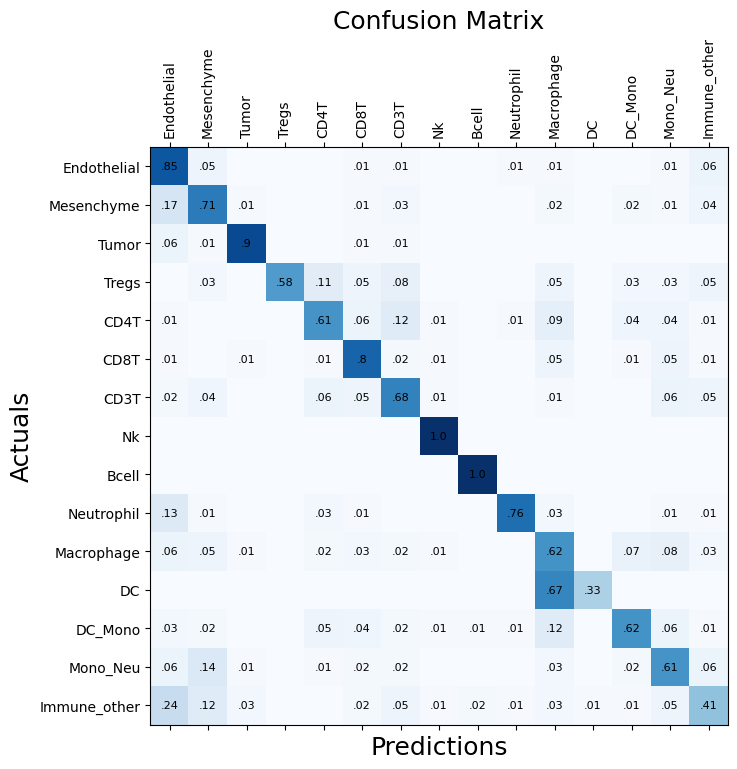

In [60]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm_norm, cmap=plt.cm.Blues,)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        if cm_norm[i, j] != 0:
          s = cm_norm[i, j]
          if s <1: #drop 0 before decimal place
            s=str(cm_norm[i, j])[1:]
          ax.text(x=j, y=i,s=s, va='center', ha='center', fontsize = 8)

ax.set_xticks(np.arange(len(cm_labels)), labels=cm_labels)
ax.set_yticks(np.arange(len(cm_labels)), labels=cm_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation='vertical')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()